In [1]:
import numpy as np
import glob
import torch
from torch import optim, nn
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import json
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict

# Initialization

In [2]:
EPOCHS = 15
PRINT_EVERY = 20
BATCH_SIZE = 64
CROP_DIMENSION = 224
MEANS = [0.485, 0.456, 0.406]
STANDARD_DEVIATIONS = [0.229, 0.224, 0.225]
RESIZE_DIMENSION = 256
Num_class = 102

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Method Playground

In [4]:
def plot_flowers(tensor, tensor_class_idx, count=1, normalize=True):
    
    images, labels = next(tensor)
    a = np.floor(count**0.5).astype(int)
    b = np.ceil(1.*count/a).astype(int)
    fig = plt.figure(figsize=(3.*b,3.*a))
    for i in range(1,count+1):
        ax = fig.add_subplot(a,b,i)
        ax.plot([1,2,3],[1,2,3])
        forDisplay = images[i].numpy().transpose((1, 2, 0))

        if normalize:
            mean = np.array(MEANS)
            standard_deviation = np.array(STANDARD_DEVIATIONS)
            forDisplay = standard_deviation * forDisplay + mean
            forDisplay = np.clip(forDisplay, 0, 1)
        ax.imshow(forDisplay)
        ax.set_title(cat_to_name.get(get_dictionary_key(tensor_class_idx, labels[i].item())))
        ax.set_axis_off()
    #fig.suptitle("%d Flowers" % count, fontsize=16)
    
    plt.show()

def get_dictionary_key(dictionary, value):
    """Return the dictionary key for the requested value.

    :param dictionary: the source dictionary
    :param value:(str) the requested value
    :return:
    """
    return {val: key for key, val in dictionary.items()}[value]

# Load Data
Download from http://www.robots.ox.ac.uk/~vgg/data/flowers/102/

In [5]:
train_dir = 'Datasets/flowers/flower_data/train/'
valid_dir = 'Datasets/flowers/flower_data/valid/'

In [6]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(CROP_DIMENSION),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(MEANS, STANDARD_DEVIATIONS)
                                      ])

valid_transforms = transforms.Compose([transforms.Resize(RESIZE_DIMENSION), 
                                      transforms.CenterCrop(CROP_DIMENSION), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize(MEANS, STANDARD_DEVIATIONS)
                                     ])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE)

In [7]:
cat_to_name = dict()
# url => https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1
with open("Datasets/flowers/flower_data/cats.txt") as f:
    for i,row in enumerate(f.readlines()):
        cat_to_name[str(i+1)] = row.strip().replace("'",'')

In [8]:
train_class_idx = train_dataset.class_to_idx
valid_class_idx = train_dataset.class_to_idx

# Show Sample Data

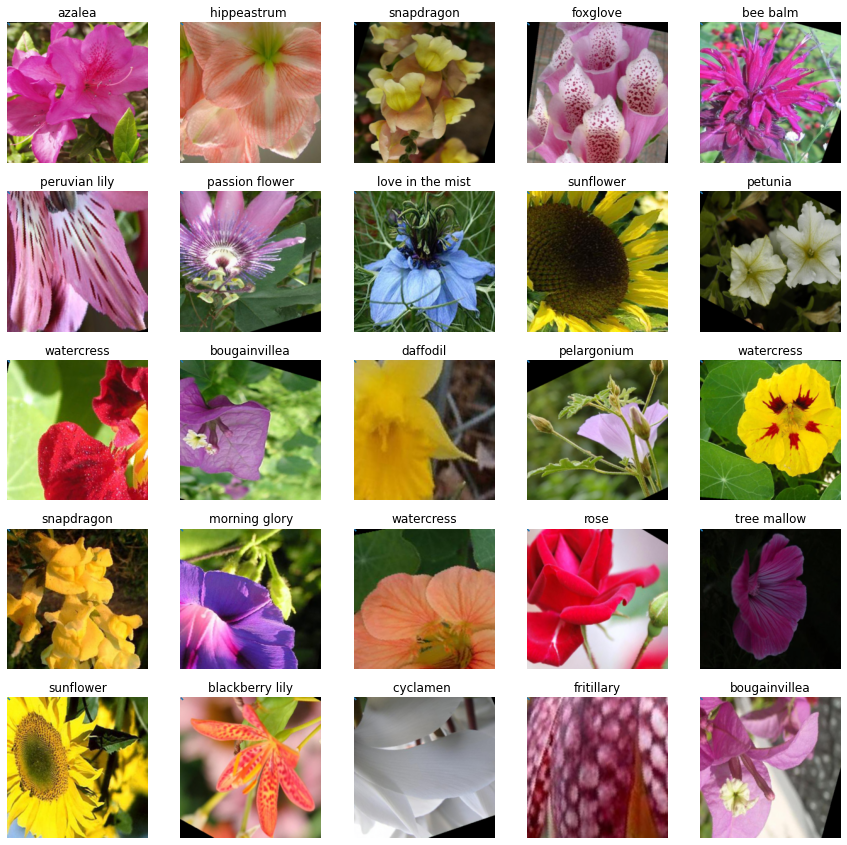

In [9]:
plot_flowers(iter(train_loader), train_class_idx, 25)

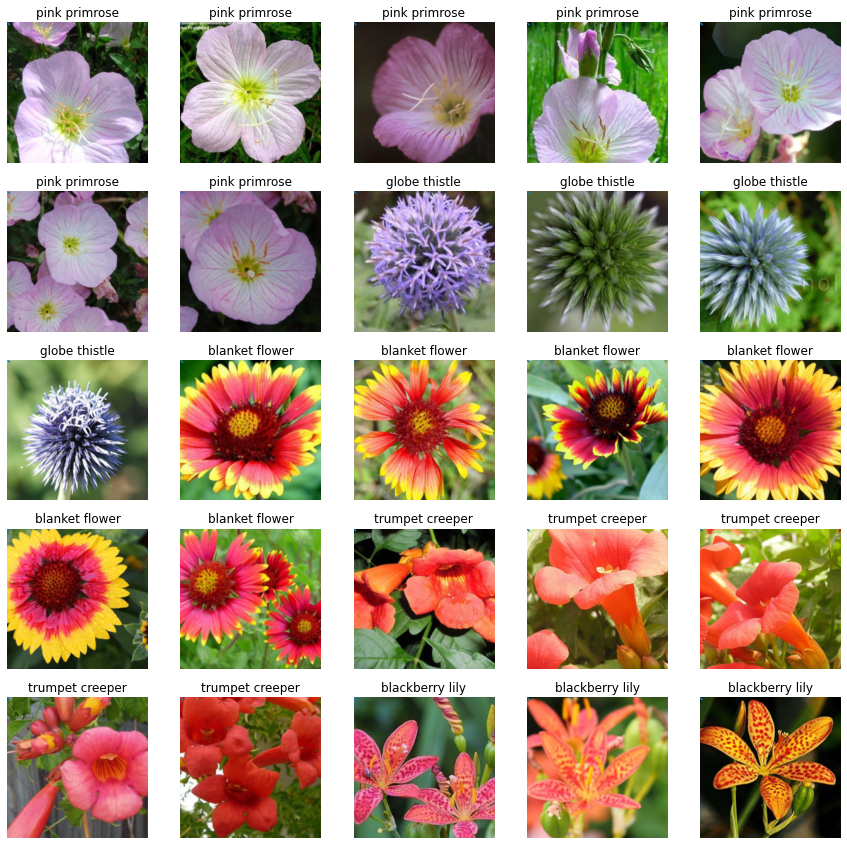

In [10]:
plot_flowers(iter(valid_loader), valid_class_idx, 25)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. I will choose from the pretrained models in torchvision.models to get the image features. I will then build and train a new feed-forward classifier using those features.

The process will be broken down into multiple steps:

* Load a pre-trained network
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training I will be updating only the weights of the feed-forward network.

In [11]:
ARCHITECTURE = 'vgg11'
AVAILABLE_MODELS = ['vgg11', 'vgg13', 'vgg16', 'vgg19', 'alexnet']

In [12]:
if ARCHITECTURE in AVAILABLE_MODELS:
    neural_network_model = getattr(models, ARCHITECTURE)(pretrained=True)
    if ARCHITECTURE == 'alexnet':
        current_in_features = neural_network_model.classifier._modules['1'].in_features
    else:
        current_in_features = neural_network_model.classifier._modules['0'].in_features
else:
    # Raise exception if architecture doesn't match available models
    raise Exception("Requested pretrained model unavailable for selection")

#### Freeze parameters so we don't backpropagate through them

In [13]:
for param in neural_network_model.parameters():
    param.requires_grad = False

#### Set the Custom Classification Layers

In [14]:
nn_classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(current_in_features, 512)),
    ('dropout1', nn.Dropout(p=0.1)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(512, 256)),
    ('dropout2', nn.Dropout(p=0.1)),
    ('relu2', nn.ReLU()),
    ('fc3', nn.Linear(256, 128)),
    ('dropout3', nn.Dropout(p=0.1)),
    ('relu3', nn.ReLU()),
    ('output', nn.Linear(128, Num_class)),
    ('logsoftmax', nn.LogSoftmax(dim=1))
]))
neural_network_model.classifier = nn_classifier

In [15]:
neural_network_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [16]:
print("Training on %s" % device)
print("%s batchs of %s images per batch" % (len(train_loader.batch_sampler), train_loader.batch_size))
print("Average loss and accuracy will display every %s batches" % PRINT_EVERY)
train_losses, validation_losses, validation_accuracy = [], [], []

Training on cuda:0
103 batchs of 64 images per batch
Average loss and accuracy will display every 20 batches


# Train and Validation Model

In [17]:
# Train neural network model
def train_neural_network(model, training_dataset, validation_dataset, 
                         epochs, print_every, criterion, optimizer, device):
    """
    
    :param model: 
    :param dataset: 
    :param epochs: 
    :param print_every: 
    :param criterion: 
    :param optimizer: 
    :param device: 
    :return: 
    """
    # Set model to appropriate device
    model.to(device)
    #print(model)
    batch_size = training_dataset.batch_size
    # Print training overview messages
    print("Training on %s" % device)
    print("%s batchs of %s images per batch" % (len(training_dataset.batch_sampler) * epochs, batch_size))
    print("Average loss and accuracy will display every %s batches\n" % print_every)
    
    current_iteration = 0
    
    for epoch in range(epochs):
        epoch_loss = 0
        model.train()
        print("Working on Epoch: %s/%s" % (epoch+1, epochs))
        print("---------------------------------------")
        
        for ii, (inputs, labels) in enumerate(training_dataset):
            current_iteration += 1
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Set all optimizer gradients to zero
            optimizer.zero_grad()
            
            # Forward and backward passes
            outputs = model.forward(inputs)
#             print(outputs.size(), F.one_hot(labels, num_classes=102).size(), labels.size())
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            
            # Update loss for current epoch
            epoch_loss += loss.item()
            
            # Display Average Loss and Accuracy if needed
            if current_iteration % print_every == 0:
                print("---------------------------------------")
                print("Current status Batch %s: Images %s to %s." % (current_iteration, batch_size * 
                                                                      current_iteration, batch_size *
                                                                      (current_iteration + 1)))
                validation_correct, validation_total, validation_loss = check_neural_network_accuracy(model, 
                                                                          validation_dataset,
                                                                          device,
                                                                          criterion)
                train_losses.append(epoch_loss / print_every)
                validation_losses.append(validation_loss / print_every)
                validation_accuracy.append((validation_correct / validation_total) * 100)
                print("Training Loss: {:.3f}".format(epoch_loss / print_every),
                      " - Validation Loss: {:.3f}".format(validation_loss / print_every),
                      " - Validation Accuracy: %d%%" % ((validation_correct / validation_total) * 100))
                epoch_loss = 0
                
                
def check_neural_network_accuracy(model, dataset, device, criterion, correct=0, total=0):    
    print("Checking accuracy:")
    loss = 0
    model.to(device)
    model.eval()
    
    # Check accuracy without calculating gradient
    with torch.no_grad():
        for ii, (inputs, labels) in enumerate(dataset):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            current_loss = criterion(outputs, labels)
            # Update loss for current training
            loss += current_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    model.train()
    
    return correct, total, loss

# Adam optimization over Stochastic Gradient Descent

In [18]:
criterion = nn.NLLLoss()
learning_rate = 0.003
optimizer = optim.Adam(neural_network_model.classifier.parameters(), lr=learning_rate)

In [19]:
train_neural_network(neural_network_model,
                     train_loader,
                     valid_loader,
                     EPOCHS,
                     PRINT_EVERY,
                     criterion,
                     optimizer,
                     device)

Training on cuda:0
1545 batchs of 64 images per batch
Average loss and accuracy will display every 20 batches

Working on Epoch: 1/15
---------------------------------------
torch.Size([64, 102]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64, 102]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64, 102]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64, 102]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64, 102]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64, 102]) torch.Size([64, 102]) torch.Size([64])


KeyboardInterrupt: 

# Review loss and accuracy

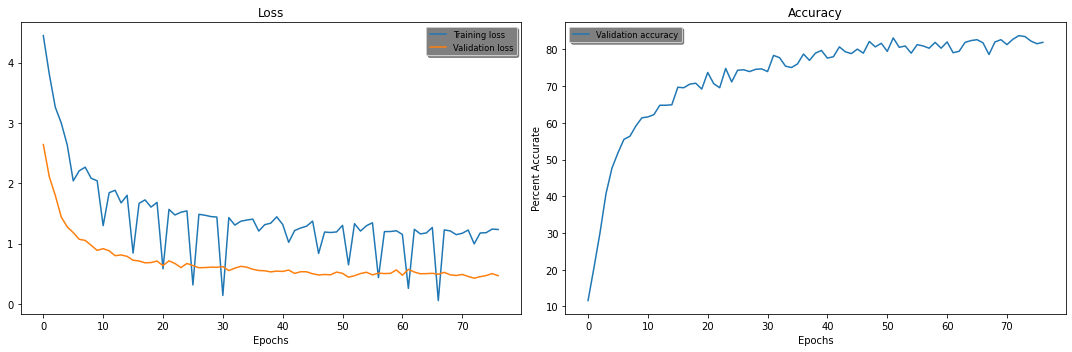

In [31]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
legend = plt.legend(loc='upper right', shadow=True, fontsize='small')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C7')

plt.subplot(1, 2, 2)
plt.plot(validation_accuracy, label='Validation accuracy')
plt.title('Accuracy')
plt.ylabel('Percent Accurate')
plt.xlabel('Epochs')
legend = plt.legend(loc='upper left', shadow=True, fontsize='small')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C7')
plt.tight_layout()